# Benchmarking

This notebook explores two parameters that affect the `FileSenderClient` performance: `concurrent_reads` and `concurrent_requests`, which are both constructor parameters. `concurrent_reads` sets a limit on the number of chunks of file data that can loaded into memory at the same time. Therefore a lower number for this parameter is expected to reduce memory usage but also increase runtime. `concurrent_requests` sets a limit on the number of requests that can be run at the same time. Reducing this is likely to affect runtime only.

The built-in `benchmark` function can be used to run the comparison. The below code benchmarks an upload using 3 files, each of which is 100 MB. We test a read limit of 1-10 and a request limit of 1-10.

In [26]:
from filesender.benchmark import benchmark
from os import environ
import itertools

read_limit, req_limit = zip(*itertools.product(range(1, 11), range(1, 11)))
with make_tempfiles(size=100_000_000, n=3) as paths
    results = benchmark(req_limit=req_limit, read_limit=read_limit, apikey=environ["API_KEY"], base_url=environ["BASE_URL"], recipient=environ["RECIPIENT"], username=environ["USERNAME"])

Transform the results into a data frame for analysis:

In [34]:
import pandas as pd
result_df = pd.DataFrame({
    "time": (result.time for result in results),
    "memory": (result.memory for result in results),
    "read_limit": read_limit,
    "req_limit": req_limit
})
result_df.memory = result_df.memory / 1024 ** 2
result_df

,time,memory,read_limit,req_limit
0,9.301185,0.353081,1,1
1,5.133033,0.428543,1,2
2,4.993618,0.475758,1,3
3,3.325778,0.492138,1,4
4,3.122681,0.625664,1,5
...,...,...,...,...
95,3.143500,0.930389,10,6
96,3.581307,0.930389,10,7
97,3.462952,0.930389,10,8
98,3.101752,0.930389,10,9


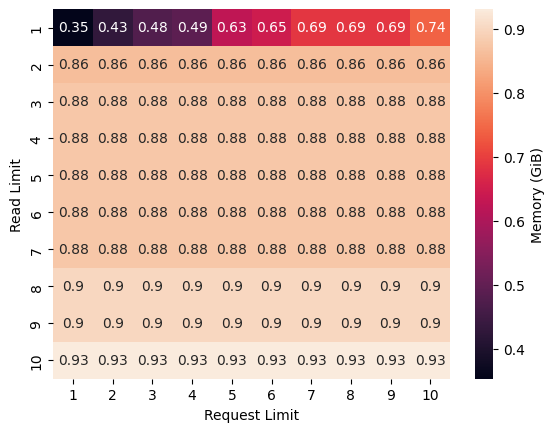

In [36]:
import seaborn as sns
ax = sns.heatmap(result_df.pivot(index="read_limit", columns="req_limit", values="memory"), annot=True)
ax.set_ylabel("Read Limit")
ax.set_xlabel("Request Limit")
ax.collections[0].colorbar.set_label("Memory (GiB)")

If the aim is to have the lowest memory footprint, then this is achieved by a read and request limit of 1. Increasing the read limit at all more than doubles the memory footprint. In contrast, increasing the request limit much more gradually increases the memory usage.

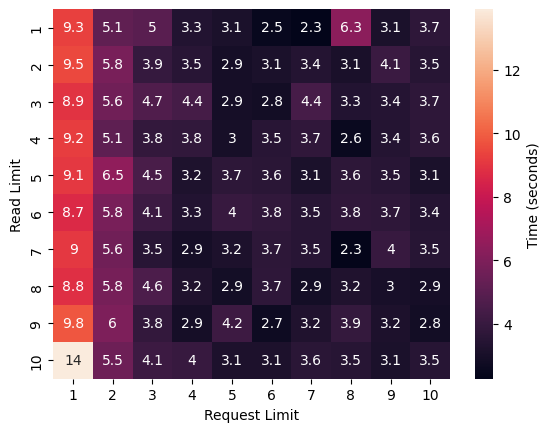

In [37]:
import seaborn as sns
ax = sns.heatmap(result_df.pivot(index="read_limit", columns="req_limit", values="time"), annot=True)
ax.set_ylabel("Read Limit")
ax.set_xlabel("Request Limit")
ax.collections[0].colorbar.set_label("Time (seconds)")

As with the above plot, lower is better. Thus, having a request limit of 1 limits the client too much. It seems that setting the read limit to 1 (which dramatically limits the memory usage), while increasing the request limit to 2 or higher is ideal in a memory limited scenario.